In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
import os
from natsort import natsorted
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import scipy.signal
from scipy.signal import find_peaks
import sys
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.fft import rfft, rfftfreq
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K

In [3]:
video = cv2.VideoCapture('/content/drive/MyDrive/UBFC_DATASET/DATASET_2/subject13/vid.avi')

fps = video.get(cv2.CAP_PROP_FPS)

print('FPS:', fps)

video.release()

FPS: 29.7903


In [4]:
npz_file_path = '/content/drive/MyDrive/everglow/ubfc-rppg/HR-npz/subject1.npz'

data = np.load(npz_file_path)
print(data['video'].shape)
print(data['wave'].shape)
print(data['hr'].shape)

(1547, 64, 64, 3)
(1547,)
(1547,)


rPPG based Average Heart Rate (BPM):  107.19847196870926
Actual Average Heart Rate:  106.70456819650937


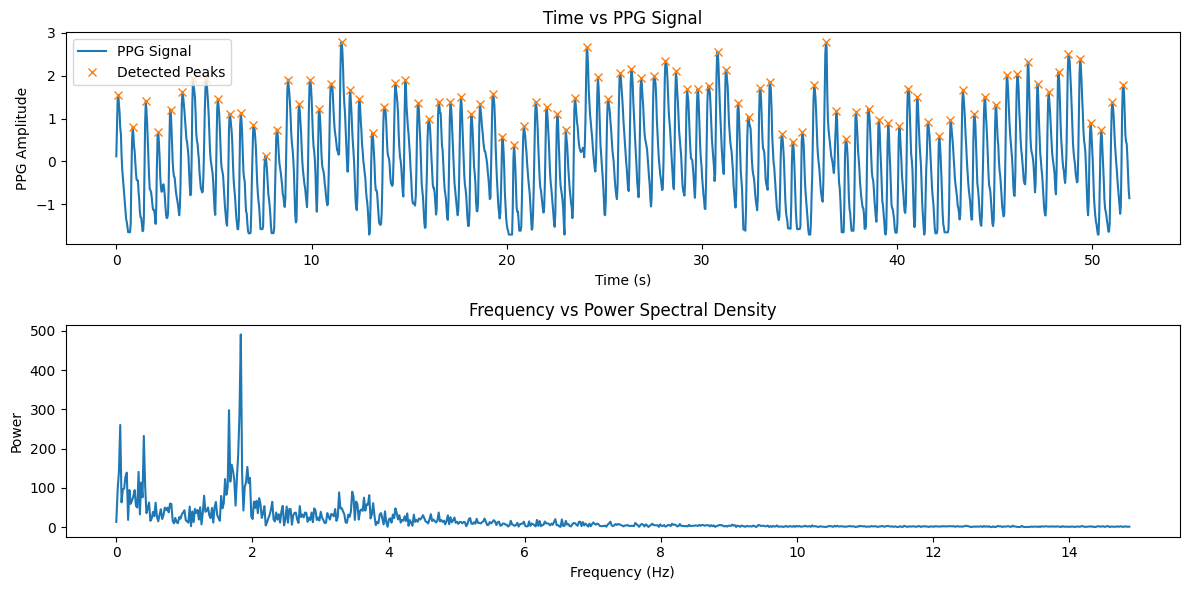

In [40]:
PPG_Signal = data['wave']
time = np.arange(PPG_Signal.size) / fps  # 30FPS로 촬영된 데이터, 시간 배열 생성

# FFT를 사용해 신호의 주파수 도메인 변환
psd = np.abs(rfft(PPG_Signal))
freqs = rfftfreq(PPG_Signal.size, 1 / fps)  # 샘플링 레이트는 초당 30프레임

# 신호에서 피크 찾기
peak_indices, _ = find_peaks(PPG_Signal, distance=10)  # 적절한 거리 설정
IBI = np.diff(peak_indices) / fps  # IBI 계산, 초 단위로 변환

# 모든 IBI 값의 평균을 계산
average_IBI = np.mean(IBI)
bpm_avg = 60 / average_IBI  # 분당 박동수 계산

print("rPPG based Average Heart Rate (BPM): ", bpm_avg)
print("Actual Average Heart Rate: ", np.mean(data['hr']))

# 플로팅
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(time, PPG_Signal, label='PPG Signal')
plt.plot(time[peak_indices], PPG_Signal[peak_indices], "x", label='Detected Peaks')
plt.title('Time vs PPG Signal')
plt.xlabel('Time (s)')
plt.ylabel('PPG Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(freqs, psd)
plt.title('Frequency vs Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.tight_layout()
plt.show()

In [7]:
df = pd.read_csv('/content/drive/MyDrive/everglow/ubfc-rppg/metadata_hr_csv_path.csv')
df

,id,path
0,1,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
1,3,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
2,4,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
3,5,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
4,8,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
5,9,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
6,10,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
7,11,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
8,12,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...
9,13,/content/drive/MyDrive/everglow/ubfc-rppg/HR-n...


In [8]:
# frame_counts = []
# for _, row in df.iterrows():
#     with np.load(row['path'], allow_pickle=True) as data:
#         video = data['video']
#         frame_counts.append(video.shape[0])  # 비디오 시퀀스의 길이 (프레임 수) 추가

# 최소 프레임 수 찾기
# min_frames = min(frame_counts)
min_frames = 1368
print(f"Minimum number of frames in the dataset: {min_frames}")

Minimum number of frames in the dataset: 1368


In [13]:
def load_dataset(df):
    video_data = []
    wave_data = []
    hr_data = []

    for _, row in df.iterrows():
        with np.load(row['path']) as data:
            video = data['video']
            wave = data['wave']
            hr = data['hr']
            if video.shape[0] > min_frames:
                video = video[:min_frames]
                wave = wave[:min_frames]
                hr = hr[:min_frames]

            video_data.append(video)
            wave_data.append(wave)
            hr_data.append(hr)
            ## 모델 입력을 HR로 할 결루
            # heart_rate = calculate_hr(wave)
            # hr_data.append(heart_rate)

    return np.array(video_data), np.array(hr_data)

video_data, hr_data = load_dataset(df)

In [15]:
class HardSwish(nn.Module):
    def forward(self, x):
        return x * F.relu6(x + 3.0) / 6.0

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=4):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Conv3d(in_channels, in_channels // reduction, kernel_size=1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Conv3d(in_channels // reduction, in_channels, kernel_size=1)
        self.hsigmoid = nn.Hardsigmoid()

    def forward(self, x):
        out = self.pool(x)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.hsigmoid(out)
        return x * out

class ConvBNHardSwish(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=3, stride=1, padding=1):
        super(ConvBNHardSwish, self).__init__()
        self.conv = nn.Conv3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm3d(out_planes)
        self.activation = HardSwish()

    def forward(self, x):
        return self.activation(self.bn(self.conv(x)))

class MobileNetV3(nn.Module):
    def __init__(self, input_shape=(1368, 64, 64, 3), num_classes=min_frames):
        super(MobileNetV3, self).__init__()
        self.layer1 = ConvBNHardSwish(input_shape[3], 16, stride=2, padding=1)
        self.layer2 = ConvBNHardSwish(16, 16, padding=1)
        self.layer3 = SEBlock(16)
        self.layer4 = nn.MaxPool3d(kernel_size=3, stride=2, padding=1)
        # 이후 레이어를 추가하고 필요에 따라 SEBlock 및 HardSwish 적용...

        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # 추가 레이어를 통한 포워드 패스...

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [16]:
# 데이터를 학습, 검증, 테스트 세트로 분할
video_train, video_test, hr_train, hr_test = train_test_split(video_data, hr_data, test_size=0.2, random_state=42)
video_train, video_val, hr_train, hr_val = train_test_split(video_train, hr_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

print(f"video_train shape: {video_train.shape}")
print(f"video_val shape: {video_val.shape}")
print(f"video_test shape: {video_test.shape}")
print(f"hr_train shape: {hr_train.shape}")
print(f"hr_val shape: {hr_val.shape}")
print(f"hr_test shape: {hr_test.shape}")

video_train shape: (24, 1368, 64, 64, 3)
video_val shape: (9, 1368, 64, 64, 3)
video_test shape: (9, 1368, 64, 64, 3)
hr_train shape: (24, 1368)
hr_val shape: (9, 1368)
hr_test shape: (9, 1368)


In [17]:
class VideoHRDataset(Dataset):
    def __init__(self, video_data, hr_data):
        """
        video_data: 비디오 데이터 배열 (샘플 수, 프레임 수, 높이, 너비, 채널)
        hr_data: HR 신호 데이터 배열 (샘플 수, 프레임 수)
        """
        self.video_data = video_data
        self.hr_data = hr_data

    def __len__(self):
        return len(self.video_data)

    def __getitem__(self, idx):
        video = self.video_data[idx]
        hr = self.hr_data[idx]
        return torch.from_numpy(video).permute(3, 0, 1, 2).float(), torch.from_numpy(hr).float()  # 채널 첫 번째로 이동

# 데이터셋 인스턴스 생성
train_dataset = VideoHRDataset(video_train, hr_train)
val_dataset = VideoHRDataset(video_val, hr_val)
test_dataset = VideoHRDataset(video_test, hr_test)

# DataLoader 인스턴스 생성
batch_size = 8  # 예시로 배치 크기를 4로 설정

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [18]:
first_batch_video, first_batch_hr = next(iter(train_loader))

print("First batch video shape:", first_batch_video.shape)
print("First batch HR shape:", first_batch_hr.shape)

First batch video shape: torch.Size([8, 3, 1368, 64, 64])
First batch HR shape: torch.Size([8, 1368])


In [24]:
# 위에서 정의한 MobileNet3D 모델 인스턴스화
model = MobileNetV3(input_shape=(1368, 64, 64, 3), num_classes=min_frames)
model.cuda()  # GPU 사용 설정

# 손실 함수 및 최적화 알고리즘 설정
criterion = nn.MSELoss()  # 회귀 문제이므로 Mean Squared Error 손실 함수 사용
optimizer = optim.Adam(model.parameters(), lr=0.01)  # 학습률은 실험적으로 조정

# 훈련 루프
num_epochs = 1000  # 에폭 수는 실험적으로 조정

for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    for video, hr in train_loader:
        video = video.cuda()  # 입력 데이터를 GPU로 이동
        hr = hr.cuda()  # 타겟 데이터를 GPU로 이동

        optimizer.zero_grad()  # 그래디언트 초기화

        outputs = model(video)  # 모델의 순전파
        loss = criterion(outputs, hr.unsqueeze(1))  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 최적화

        running_loss += loss.item() * video.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)

    # 검증 루프
    model.eval()  # 모델을 평가 모드로 설정
    val_loss = 0.0
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for video, hr in val_loader:
            video = video.cuda()
            hr = hr.cuda()

            outputs = model(video)
            loss = criterion(outputs, hr.unsqueeze(1))

            val_loss += loss.item() * video.size(0)
    val_loss /= len(val_loader.dataset)

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")

Epoch 1, Train Loss: 9285.6753, Val Loss: 9314.5878
Epoch 2, Train Loss: 9238.8932, Val Loss: 9085.7040
Epoch 3, Train Loss: 9170.2739, Val Loss: 9132.5111
Epoch 4, Train Loss: 9086.9061, Val Loss: 8642.5165
Epoch 5, Train Loss: 8986.6331, Val Loss: 8288.9226
Epoch 6, Train Loss: 8868.3853, Val Loss: 8177.3919
Epoch 7, Train Loss: 8724.2783, Val Loss: 8647.1292
Epoch 8, Train Loss: 8541.7593, Val Loss: 8360.5112
Epoch 9, Train Loss: 8320.5352, Val Loss: 7887.9412
Epoch 10, Train Loss: 8029.1270, Val Loss: 7522.0891
Epoch 11, Train Loss: 7671.7137, Val Loss: 7922.3826
Epoch 12, Train Loss: 7276.3022, Val Loss: 6887.9667
Epoch 13, Train Loss: 6742.9564, Val Loss: 5698.9420
Epoch 14, Train Loss: 6175.6982, Val Loss: 3146.7362
Epoch 15, Train Loss: 5677.2419, Val Loss: 6248.2560
Epoch 16, Train Loss: 5085.3343, Val Loss: 5224.9403
Epoch 17, Train Loss: 4535.2461, Val Loss: 5683.8506
Epoch 18, Train Loss: 4006.1214, Val Loss: 3757.4902
Epoch 19, Train Loss: 3534.0689, Val Loss: 4114.1324
Ep

Average Mean Squared Error on Test Dataset: 543.0888


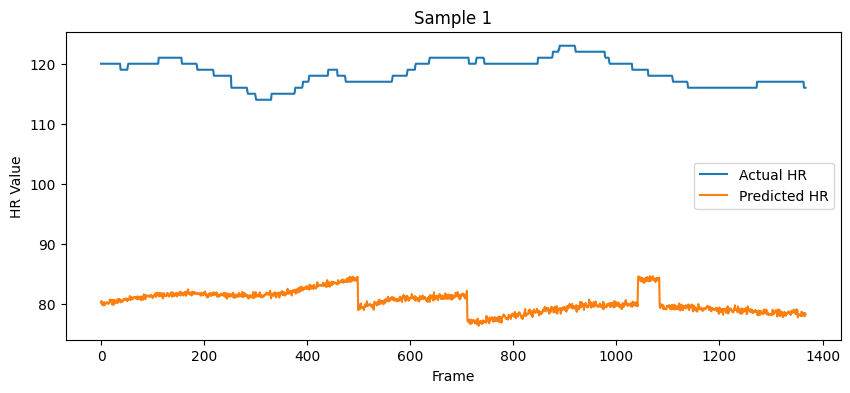

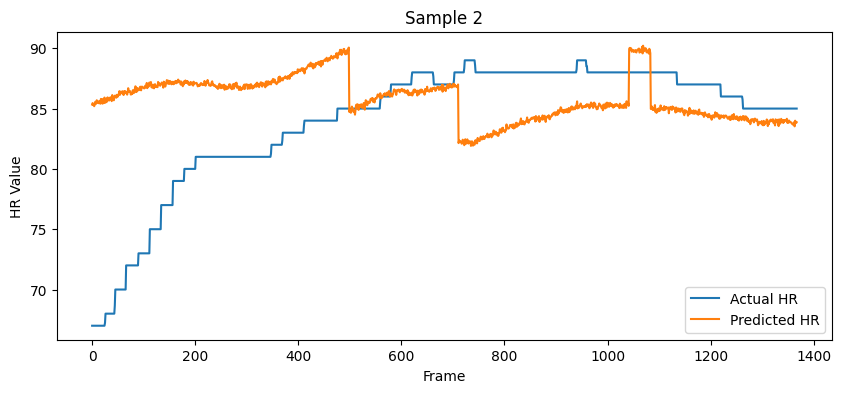

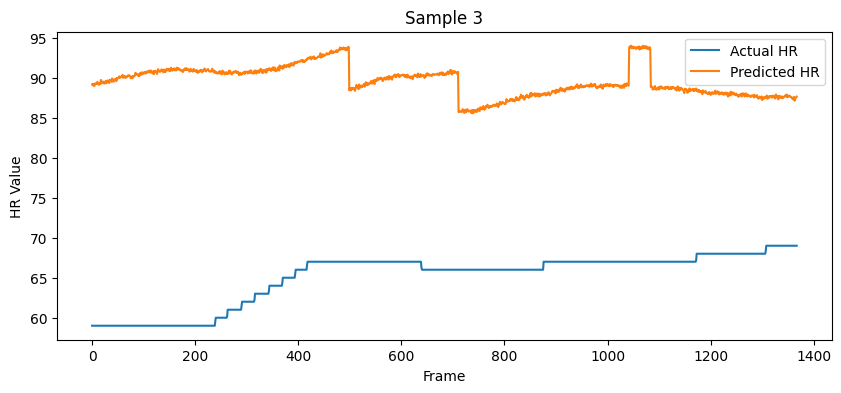

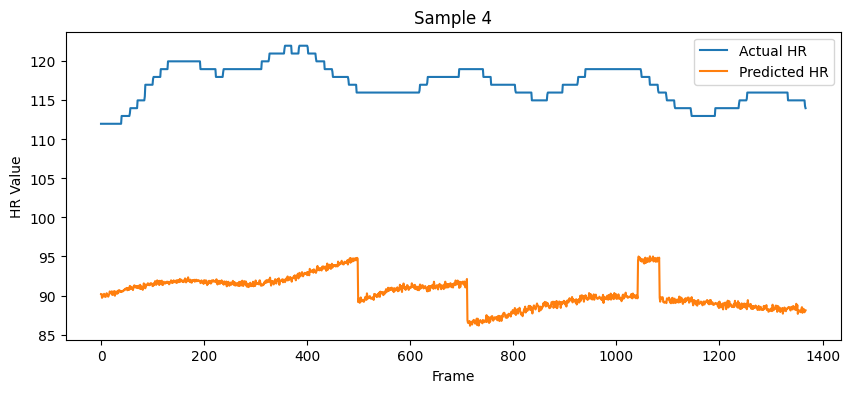

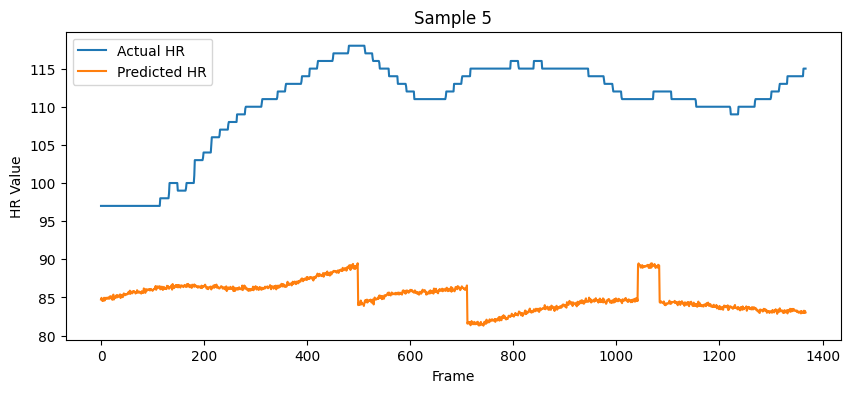

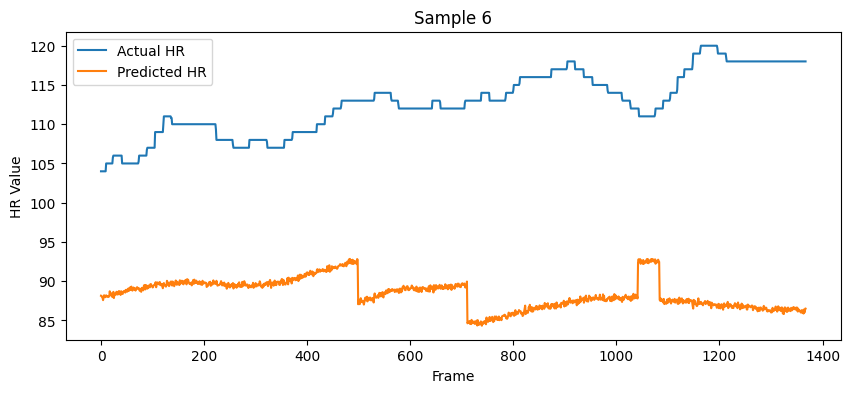

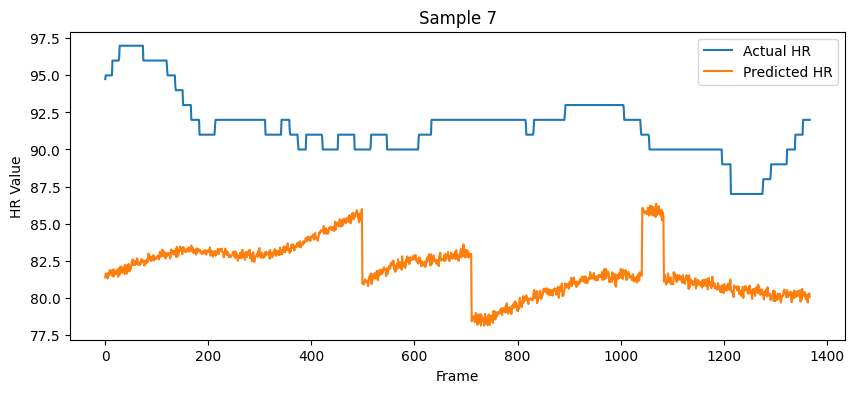

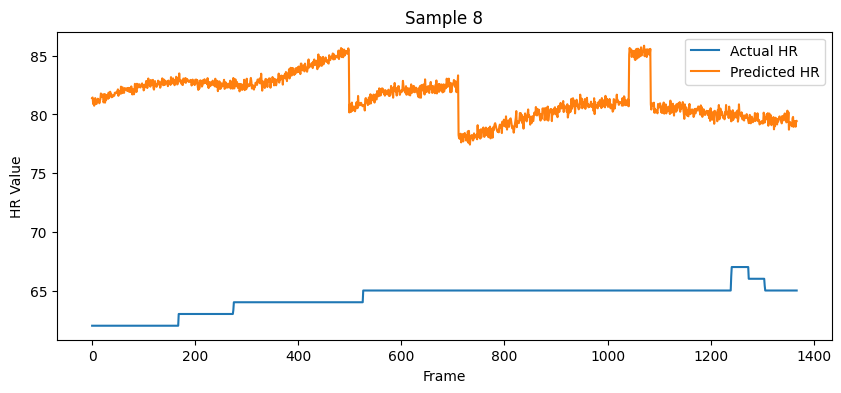

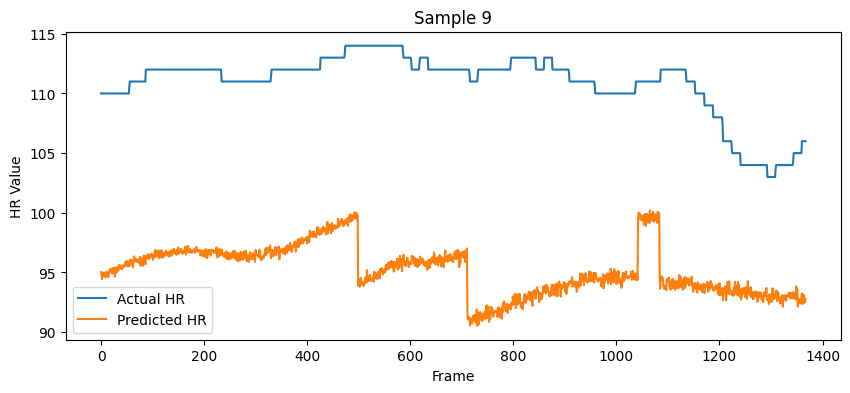

In [25]:
# 테스트 데이터에 대한 모델의 예측과 실제 값을 저장할 리스트
test_predictions = []
test_ground_truth = []
total_mse = 0.0  # 총 MSE 손실을 저장할 변수

# 모델을 평가 모드로 설정
model.eval()

# 테스트 데이터셋을 통한 반복
with torch.no_grad():
    for video, hr in test_loader:
        video = video.cuda()
        hr = hr.cuda()

        # 모델 예측
        outputs = model(video)

        # 예측 결과 저장
        test_predictions.extend(outputs.cpu().numpy())
        test_ground_truth.extend(hr.cpu().numpy())

        loss = criterion(outputs, hr.unsqueeze(1))
        total_mse += loss.item() * video.size(0)

average_mse = total_mse / len(test_loader.dataset)
print(f"Average Mean Squared Error on Test Dataset: {average_mse:.4f}")

# 각 테스트 샘플에 대해 실제 값과 예측 값을 비교하는 plot 생성
for i, (pred, true) in enumerate(zip(test_predictions, test_ground_truth)):
    plt.figure(figsize=(10, 4))
    plt.plot(true, label='Actual HR')
    plt.plot(pred, label='Predicted HR')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Frame')
    plt.ylabel('HR Value')
    plt.legend()
    plt.show()
